In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
import geopandas
import numpy as np
import shap
import torch.nn.functional as F
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

from sktime.forecasting.arima import AutoARIMA, ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from prophet import Prophet
from sktime.forecasting.base import ForecastingHorizon
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer
from sklearn.linear_model import PoissonRegressor

from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
from torch import nn
from torch_geometric_temporal.signal import StaticGraphTemporalSignal, temporal_signal_split
from torch_geometric_temporal.nn.attention.stgcn import STConv

from tqdm import tqdm
from torch.nn import PoissonNLLLoss
import time

import mlflow
import os
import random

### Setup MLflow

In [ ]:
tracking_uri = os.environ['MLFLOW_TRACKING_URI']
mlflow.set_tracking_uri(tracking_uri)

mlflow.set_experiment("rides_forecasting")

### Retrieve weather data

In [40]:
from meteostat import Point, Daily, Hourly
from datetime import datetime

start = datetime(2020, 1, 1)
end = datetime(2023, 2, 1)
location = Point(41.8667, -87.6, 181)

In [41]:
data = Hourly(location, start, end)
data = data.fetch()

In [42]:
data.tail()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2023-01-31 20:00:00,-10.6,-21.0,42.0,0.0,<NA>,280.0,14.8,<NA>,1030.5,<NA>,1.0
2023-01-31 21:00:00,-10.6,-21.0,42.0,0.0,<NA>,280.0,14.8,<NA>,1029.8,<NA>,2.0
2023-01-31 22:00:00,-10.6,-22.1,38.0,0.0,<NA>,290.0,13.0,<NA>,1030.0,<NA>,1.0
2023-01-31 23:00:00,-11.1,-22.0,40.0,0.0,<NA>,270.0,14.8,<NA>,1030.4,<NA>,1.0
2023-02-01 00:00:00,-12.2,-22.2,43.0,0.0,<NA>,260.0,11.2,<NA>,1030.8,<NA>,1.0


In [43]:
data.to_csv("./weatherdata/weather.csv")

In [92]:
weather = pd.read_csv("./weatherdata/weather.csv")

In [13]:
weather.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2020-01-01 00:00:00,-2.0,-6.0,74.0,NaN,NaN,280.0,24.0,NaN,1009.8,NaN,3.0
1,2020-01-01 01:00:00,-1.7,-6.1,72.0,0.0,NaN,280.0,24.1,NaN,1011.0,NaN,4.0
2,2020-01-01 02:00:00,-1.7,-5.5,75.0,0.0,NaN,270.0,20.5,NaN,1011.3,NaN,4.0
3,2020-01-01 03:00:00,-1.7,-5.5,75.0,0.0,NaN,260.0,27.7,NaN,1011.1,NaN,3.0
4,2020-01-01 04:00:00,-1.7,-5.5,75.0,0.0,NaN,270.0,14.8,NaN,1011.1,NaN,3.0


In [14]:
weather.tail()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
27044,2023-01-31 20:00:00,-10.6,-21.0,42.0,0.0,NaN,280.0,14.8,NaN,1030.5,NaN,1.0
27045,2023-01-31 21:00:00,-10.6,-21.0,42.0,0.0,NaN,280.0,14.8,NaN,1029.8,NaN,2.0
27046,2023-01-31 22:00:00,-10.6,-22.1,38.0,0.0,NaN,290.0,13.0,NaN,1030.0,NaN,1.0
27047,2023-01-31 23:00:00,-11.1,-22.0,40.0,0.0,NaN,270.0,14.8,NaN,1030.4,NaN,1.0
27048,2023-02-01 00:00:00,-12.2,-22.2,43.0,0.0,NaN,260.0,11.2,NaN,1030.8,NaN,1.0


In [93]:
weather = weather.dropna(axis=1, thresh=0.8*weather.shape[0])

In [5]:
weather.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27049 entries, 0 to 27048
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    27049 non-null  object 
 1   temp    27049 non-null  float64
 2   dwpt    27049 non-null  float64
 3   rhum    27049 non-null  float64
 4   prcp    26646 non-null  float64
 5   wdir    27049 non-null  float64
 6   wspd    27049 non-null  float64
 7   pres    27049 non-null  float64
 8   coco    26799 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.9+ MB


In [94]:
weather['time'] = pd.to_datetime(weather['time'])

In [95]:
weather.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27049 entries, 0 to 27048
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    27049 non-null  datetime64[ns]
 1   temp    27049 non-null  float64       
 2   dwpt    27049 non-null  float64       
 3   rhum    27049 non-null  float64       
 4   prcp    26646 non-null  float64       
 5   wdir    27049 non-null  float64       
 6   wspd    27049 non-null  float64       
 7   pres    27049 non-null  float64       
 8   coco    26799 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 1.9 MB


Lag the weather data since it is hourly and to avoid data leakage when we combine with the 30 minute interval ride data

In [96]:
weather['rain'] = weather['prcp'] > 0

In [97]:
cols_to_lag = weather.columns.drop("time")

for col in cols_to_lag:
    weather[col] = weather[col].shift(-1)

In [12]:
weather.to_csv("weather_features.csv", index=False)

### Connect to duckdb

In [78]:
conn = duckdb.connect("rides.ddb")

In [ ]:
# Run after done running cells
conn.close()

In [79]:
def fetch_df_from_query(query):
    return conn.execute(query).fetch_df()

### Get Chicago community data

In [20]:
chicago = geopandas.read_file('https://data.cityofchicago.org/resource/igwz-8jzy.geojson')
chicago = chicago.to_crs('EPSG:4326')

# Construct Adjacency matrix

In [9]:
def count_trips_per_group(group):
    query = f"""
    SELECT {group}, COUNT(trip_id) as num_trips
    FROM RIDES_EXTRA_VARS 
    GROUP BY {group}
    """
    count_per_group = conn.execute(query)\
        .fetch_df()\
        .sort_values(by="num_trips", ascending=False)\
        .set_index(group)\

    return count_per_group

count_by_pickup_community_area = count_trips_per_group("pickup_community_area")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [36]:
count_by_pickup_community_area

,num_trips
pickup_community_area,
8.0,20596874
NaN,12610963
28.0,10459624
32.0,10201041
6.0,9164986
...,...
37.0,135898
74.0,131410
52.0,97713


Save so we we don't need to use duckdb again

In [96]:
count_by_pickup_community_area.to_csv("count_by_pickup_community_area.csv")

In [19]:
count_by_pickup_community_area = pd.read_csv("count_by_pickup_community_area.csv",index_col=0)

In [21]:
def remove_decimal(x):
    if x:
        x = x.replace(".0", "")
    return x

def convert_community_area_to_int(df):
    df['pickup_community_area'] = (
        df['pickup_community_area']\
            .astype(str)\
            .apply(lambda x: remove_decimal(x))
    )
    return df

count_by_pickup_community_area_geo = convert_community_area_to_int(count_by_pickup_community_area.reset_index())

# Merge with the Chicago geo data
count_by_pickup_community_area_geo = count_by_pickup_community_area_geo.merge(
    chicago, 
    left_on="pickup_community_area", 
    right_on="area_num_1"
)

In [22]:
count_by_pickup_community_area_geodf = geopandas.GeoDataFrame(count_by_pickup_community_area_geo, geometry="geometry")

In [23]:
count_by_pickup_community_area_geodf["pickup_community_area"] = count_by_pickup_community_area_geodf["pickup_community_area"].astype(int)

In [24]:
count_by_pickup_community_area_geodf = count_by_pickup_community_area_geodf.sort_values(by="pickup_community_area")
count_by_pickup_community_area_geodf["pickup_community_area"] = count_by_pickup_community_area_geodf["pickup_community_area"].astype('str')
count_by_pickup_community_area_geodf = count_by_pickup_community_area_geodf.reset_index(drop=True)

### Adjaceny matrix based on overlap of community borders

In [183]:
n = count_by_pickup_community_area_geodf.shape[0]
A = np.zeros((n, n))

sindex = count_by_pickup_community_area_geodf.sindex

for i, geom in enumerate(count_by_pickup_community_area_geodf.geometry):
    possible_matches_idx = list(sindex.intersection(geom.bounds))
    for j in possible_matches_idx:
        if i != j:
            geom_j = count_by_pickup_community_area_geodf.loc[j, 'geometry']
            if geom.touches(geom_j):
                shared_border = geom.intersection(geom_j).length
                A[i, j] = shared_border

### Adjaceny matrix based on distance of community centroids (This method was used)

In [25]:
n = count_by_pickup_community_area_geodf.shape[0]
A = np.zeros((n, n))

sindex = count_by_pickup_community_area_geodf.sindex

for i, geom in enumerate(count_by_pickup_community_area_geodf.geometry):
    possible_matches_idx = list(sindex.intersection(geom.bounds))
    for j in possible_matches_idx:
        if i != j:
            geom_j = count_by_pickup_community_area_geodf.loc[j, 'geometry']
            if geom.touches(geom_j):
                geom_centroid = geom_j.centroid
                dist = geom.centroid.distance(geom_centroid)
                A[i, j] = dist

In [9]:
A[0,:]

array([0.        , 0.02611732, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [10]:
A.size

5929

### Row stadardize

In [26]:
def row_standardize(X:np.ndarray):
    return X / X.sum(axis=1)

In [27]:
A = row_standardize(A)

In [32]:
np.save("adjacency_matrix_distance.npy", A)

### Edge DF

In [28]:
def create_edge_df(data):
    data_ = data.copy()
    data_['geometry_buffer'] = data_.geometry.buffer(0.001)
    buffers = data_.set_geometry('geometry_buffer')

    join = geopandas.sjoin(buffers, data_, how='inner', predicate='intersects')

    edges_df = join[join.index != join['index_right']]
    edges_df = edges_df[['area_num_1_left', 'pickup_community_area_right']].astype(int)

    return edges_df

In [29]:
edges_df = create_edge_df(count_by_pickup_community_area_geodf)

C:\Users\armym\AppData\Local\Temp\ipykernel_27320\1892840954.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_['geometry_buffer'] = data_.geometry.buffer(0.001)


In [30]:
edges_np = edges_df.to_numpy()

In [31]:
edges_np = edges_np - 1

In [32]:
edges_np

array([[ 0, 76],
       [ 0,  1],
       [ 1,  3],
       [ 1, 76],
       [ 1,  0],
       [ 1, 12],
       [ 2,  4],
       [ 2,  5],
       [ 2,  3],
       [ 2, 76],
       [ 3,  4],
       [ 3, 15],
       [ 3, 13],
       [ 3,  5],
       [ 3,  2],
       [ 3, 76],
       [ 3,  1],
       [ 3, 12],
       [ 4,  6],
       [ 4, 21],
       [ 4, 20],
       [ 4, 15],
       [ 4, 13],
       [ 4,  5],
       [ 4,  2],
       [ 4,  3],
       [ 5,  6],
       [ 5,  4],
       [ 5,  2],
       [ 5,  3],
       [ 6,  7],
       [ 6, 23],
       [ 6, 21],
       [ 6,  4],
       [ 6,  5],
       [ 7, 31],
       [ 7, 27],
       [ 7, 23],
       [ 7,  6],
       [ 8,  9],
       [ 9, 75],
       [ 9, 10],
       [ 9, 11],
       [ 9,  8],
       [10, 14],
       [10,  9],
       [10, 11],
       [11, 15],
       [11, 14],
       [11, 13],
       [11, 10],
       [11, 12],
       [11,  9],
       [12, 13],
       [12,  3],
       [12,  1],
       [12, 11],
       [13,  4],
       [13, 15

In [33]:
edges_np[0]

array([ 0, 76])

In [32]:
np.save("edges.npy", edges_np)

In [6]:
import numpy as np
edges_np = np.load("graph_files/edges.npy")

In [7]:
edges_np.shape

(408, 2)

In [34]:
edge_weights = []
for i, edge in enumerate(edges_np):
    node_num = edge[0] - 1
    idx = edge[1] - 1 # idx range starts at 1
    weight = A[node_num, idx]
    edge_weights.append(weight)

edge_weights = np.array(edge_weights)

In [35]:
edge_weights

array([0.        , 0.4776777 , 0.        , 0.        , 0.2216943 ,
       0.        , 0.10064059, 0.        , 0.        , 0.        ,
       0.12098201, 0.        , 0.        , 0.12202684, 0.        ,
       0.        , 0.        , 0.        , 0.37971431, 0.        ,
       0.        , 0.        , 0.30182441, 0.10135362, 0.2245661 ,
       0.29977345, 0.24126154, 0.10130394, 0.        , 0.30221418,
       0.12691886, 0.        , 0.        , 0.16196871, 0.10296158,
       0.        , 0.        , 0.        , 0.19345468, 0.        ,
       0.        , 0.1268696 , 0.        , 0.        , 0.        ,
       1.        , 0.41818605, 0.09931836, 0.        , 0.        ,
       0.16945292, 0.0823262 , 0.        , 0.29545178, 0.        ,
       0.        , 0.25160263, 0.135855  , 0.        , 0.0796803 ,
       0.        , 0.15076696, 0.        , 0.        , 0.        ,
       0.06074595, 0.16865327, 0.12789846, 0.        , 0.        ,
       0.        , 0.12167536, 0.        , 0.17477753, 0.22399

In [28]:
edge_weights.dtype

dtype('float64')

In [31]:
np.save("edge_weights.npy", edge_weights)

## Data Prep

In [81]:
query = """ 
 SELECT 
    pickup_community_area,
    time_bucket(INTERVAL '30 minutes', trip_start_timestamp) as interval,
    count(trip_id) as num_rides,
    AVG(fare) as average_fare,
    AVG(trip_total) as average_trip_total,
    MAX(trip_start_day_of_week) as trip_start_day_of_week,
    MAX(trip_start_hour) as trip_start_hour
FROM RIDES_EXTRA_VARS
GROUP BY pickup_community_area, interval
"""

df = fetch_df_from_query(query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [13]:
df

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,trip_start_day_of_week,trip_start_hour
0,2.0,2022-11-11 11:30:00,38,13.223684,17.980263,5,11
1,49.0,2022-11-11 11:30:00,36,11.571429,15.117714,5,11
2,45.0,2021-05-31 06:30:00,1,37.500000,38.700000,1,6
3,11.0,2021-05-31 06:30:00,6,11.250000,14.233333,1,6
4,12.0,2021-05-31 04:00:00,3,13.333333,18.386667,1,4
...,...,...,...,...,...,...,...
3736457,70.0,2021-06-15 10:30:00,13,10.384615,14.834615,2,10
3736458,57.0,2021-06-15 09:30:00,9,16.944444,22.376667,2,9
3736459,23.0,2021-06-15 09:00:00,46,18.152174,23.515652,2,9
3736460,26.0,2021-06-15 09:00:00,17,16.323529,19.325294,2,9


In [82]:
df = df.sort_values(by=["interval", "pickup_community_area"])\
    .reset_index(drop=True)

### Make target variable

In [83]:
df['target'] = df['num_rides'].shift(-1)

In [84]:
# Remove the row with a nan target from shifting
df = df.iloc[:-1]

In [85]:
# Number of pickup communities in Chicago
df['pickup_community_area'].nunique()

77

In [86]:
# Na pickup communities are pickups outside of Chicago
df = df[~df["pickup_community_area"].isna()]

In [87]:
# Number unique timestamps for pickups
n_time_steps = df['interval'].nunique()

In [88]:
n_time_steps

49321

In [89]:
df['pickup_community_area'] = df['pickup_community_area'].astype(int)

In [90]:
df = df.dropna()

In [23]:
df.head()

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,trip_start_day_of_week,trip_start_hour,target
0,1,2020-03-09 09:30:00,65,13.653846,17.577538,1,9,50.0
1,2,2020-03-09 09:30:00,50,10.750000,14.602800,1,9,120.0
2,3,2020-03-09 09:30:00,120,12.354167,17.035000,1,9,47.0
3,4,2020-03-09 09:30:00,47,11.968085,16.276809,1,9,42.0
4,5,2020-03-09 09:30:00,42,10.595238,15.714048,1,9,274.0


In [98]:
# How="left" since weather data is on hour interval
df = df.merge(weather, left_on="interval", right_on="time", how ="left")

In [25]:
df.shape[0]

3687015

In [99]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687015 entries, 0 to 3687014
Data columns (total 18 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   pickup_community_area   3687015 non-null  int32         
 1   interval                3687015 non-null  datetime64[us]
 2   num_rides               3687015 non-null  int64         
 3   average_fare            3687015 non-null  float64       
 4   average_trip_total      3687015 non-null  float64       
 5   trip_start_day_of_week  3687015 non-null  int64         
 6   trip_start_hour         3687015 non-null  int64         
 7   target                  3687015 non-null  float64       
 8   time                    1843765 non-null  datetime64[ns]
 9   temp                    1843765 non-null  float64       
 10  dwpt                    1843765 non-null  float64       
 11  rhum                    1843765 non-null  float64       
 12  prcp          

In [100]:
df = df.ffill()

In [101]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687015 entries, 0 to 3687014
Data columns (total 18 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   pickup_community_area   3687015 non-null  int32         
 1   interval                3687015 non-null  datetime64[us]
 2   num_rides               3687015 non-null  int64         
 3   average_fare            3687015 non-null  float64       
 4   average_trip_total      3687015 non-null  float64       
 5   trip_start_day_of_week  3687015 non-null  int64         
 6   trip_start_hour         3687015 non-null  int64         
 7   target                  3687015 non-null  float64       
 8   time                    3686939 non-null  datetime64[ns]
 9   temp                    3686939 non-null  float64       
 10  dwpt                    3686939 non-null  float64       
 11  rhum                    3686939 non-null  float64       
 12  prcp          

In [102]:
df.head()

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,trip_start_day_of_week,trip_start_hour,target,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,rain
0,1,2020-03-09 09:30:00,65,13.653846,17.577538,1,9,50.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2020-03-09 09:30:00,50,10.750000,14.602800,1,9,120.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2020-03-09 09:30:00,120,12.354167,17.035000,1,9,47.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2020-03-09 09:30:00,47,11.968085,16.276809,1,9,42.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2020-03-09 09:30:00,42,10.595238,15.714048,1,9,274.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since df starts at 2020-03-09 09:30:00 and weather is on an hourly interval, we cannot fill the first 75 rows of weather data in df so we just drop these rows.

In [57]:
weather[weather.time.dt.month==3]

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
1440,2020-03-01 00:00:00,0.6,-8.4,51.0,0.0,190.0,13.0,1022.1,2.0
1441,2020-03-01 01:00:00,-0.6,-6.8,63.0,0.0,190.0,11.2,1021.9,2.0
1442,2020-03-01 02:00:00,-1.1,-6.6,66.0,0.0,180.0,14.8,1021.2,2.0
1443,2020-03-01 03:00:00,-1.1,-6.6,66.0,0.0,180.0,7.6,1020.6,2.0
1444,2020-03-01 04:00:00,-1.1,-6.1,69.0,0.0,190.0,11.2,1020.2,2.0
...,...,...,...,...,...,...,...,...,...
19699,2022-03-31 19:00:00,3.9,-1.1,70.0,0.0,320.0,18.4,1000.4,14.0
19700,2022-03-31 20:00:00,3.3,-1.1,73.0,0.0,300.0,20.5,1001.3,12.0
19701,2022-03-31 21:00:00,2.8,-0.7,78.0,0.2,310.0,14.8,1002.3,4.0
19702,2022-03-31 22:00:00,3.3,-1.6,70.0,0.1,310.0,14.8,1003.4,4.0


In [29]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687015 entries, 0 to 3687014
Data columns (total 18 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   pickup_community_area   3687015 non-null  int32         
 1   interval                3687015 non-null  datetime64[us]
 2   num_rides               3687015 non-null  int64         
 3   average_fare            3687015 non-null  float64       
 4   average_trip_total      3687015 non-null  float64       
 5   trip_start_day_of_week  3687015 non-null  int64         
 6   trip_start_hour         3687015 non-null  int64         
 7   target                  3687015 non-null  float64       
 8   time                    3686939 non-null  datetime64[ns]
 9   temp                    3686939 non-null  float64       
 10  dwpt                    3686939 non-null  float64       
 11  rhum                    3686939 non-null  float64       
 12  prcp          

In [34]:
df.iloc[:77].info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   pickup_community_area   77 non-null     int32         
 1   interval                77 non-null     datetime64[us]
 2   num_rides               77 non-null     int64         
 3   average_fare            77 non-null     float64       
 4   average_trip_total      77 non-null     float64       
 5   trip_start_day_of_week  77 non-null     int64         
 6   trip_start_hour         77 non-null     int64         
 7   target                  77 non-null     float64       
 8   time                    1 non-null      datetime64[ns]
 9   temp                    1 non-null      float64       
 10  dwpt                    1 non-null      float64       
 11  rhum                    1 non-null      float64       
 12  prcp                    1 non-null      float64     

In [103]:
df = df.dropna()

In [104]:
df = df.drop("time", axis=1)

In [32]:
df.tail()

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,trip_start_day_of_week,trip_start_hour,target,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,rain
3687010,73,2022-12-31 23:30:00,34,13.823529,17.145882,6,23,11.0,2.0,-1.3,79.0,0.0,121.0,6.0,1013.0,3.0,False
3687011,74,2022-12-31 23:30:00,11,8.636364,14.539091,6,23,22.0,2.0,-1.3,79.0,0.0,121.0,6.0,1013.0,3.0,False
3687012,75,2022-12-31 23:30:00,22,14.886364,18.453182,6,23,60.0,2.0,-1.3,79.0,0.0,121.0,6.0,1013.0,3.0,False
3687013,76,2022-12-31 23:30:00,60,25.583333,37.202833,6,23,104.0,2.0,-1.3,79.0,0.0,121.0,6.0,1013.0,3.0,False
3687014,77,2022-12-31 23:30:00,104,11.009615,14.938846,6,23,366.0,2.0,-1.3,79.0,0.0,121.0,6.0,1013.0,3.0,False


In [38]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3686939 entries, 76 to 3687014
Data columns (total 16 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   pickup_community_area   3686939 non-null  int32         
 1   interval                3686939 non-null  datetime64[us]
 2   num_rides               3686939 non-null  int64         
 3   average_fare            3686939 non-null  float64       
 4   average_trip_total      3686939 non-null  float64       
 5   trip_start_day_of_week  3686939 non-null  int64         
 6   trip_start_hour         3686939 non-null  int64         
 7   target                  3686939 non-null  float64       
 8   temp                    3686939 non-null  float64       
 9   dwpt                    3686939 non-null  float64       
 10  rhum                    3686939 non-null  float64       
 11  prcp                    3686939 non-null  float64       
 12  wdir              

### Preserve cyclical nature of hour and day of week

In [105]:
def cyclical_transform(x, period):
    return np.sin(2 * np.pi * x / period), np.cos(2 * np.pi * x / period)

In [106]:
df['trip_start_hour_sin'] = df['trip_start_hour'].apply(lambda x: cyclical_transform(x, 24)[0])
df['trip_start_hour_cos'] = df['trip_start_hour'].apply(lambda x: cyclical_transform(x, 24)[1])

df['trip_start_day_of_week_sin'] = df['trip_start_day_of_week'].apply(lambda x: cyclical_transform(x, 7)[0])
df['trip_start_day_of_week_cos'] = df['trip_start_day_of_week'].apply(lambda x: cyclical_transform(x, 7)[1])

In [107]:
df = df.drop(['trip_start_hour', 'trip_start_day_of_week'], axis=1)

In [ ]:
# apply log(x+1) transforms
df[["fare_LT", "trip_total_LT"]] = np.log(df[["average_fare", "average_trip_total"]] + 1)

In [58]:
df['rain'] = df['rain'].astype(int)

In [45]:
groups = ['interval']
graph_ts = df.groupby(groups)[df.columns.drop(groups)]
community_areas = set(df['pickup_community_area'].unique())

In [9]:
community_areas = set(df['pickup_community_area'].unique())

In [47]:
df_diff = df.copy()

In [48]:
df_diff['prcp'] = df_diff['prcp'].diff()

In [49]:
df_diff = df_diff.dropna()

### Create Feature and Target Lists

In [118]:
df = df.sort_values(['interval', 'pickup_community_area'])

In [119]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train, validation = train_test_split(train, shuffle=False, test_size=0.2)

In [51]:
train.tail()

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,target,temp,dwpt,rhum,prcp,...,wspd,pres,coco,rain,trip_start_hour_sin,trip_start_hour_cos,trip_start_day_of_week_sin,trip_start_day_of_week_cos,fare_LT,trip_total_LT
2359711,9,2021-12-29 15:30:00,3,11.666667,14.206667,18.0,1.7,-2.8,72.0,0.0,...,11.2,1014.9,4.0,False,-0.707107,-0.707107,0.433884,-0.900969,2.538974,2.721734
2359712,10,2021-12-29 15:30:00,18,15.833333,20.693333,10.0,1.7,-2.8,72.0,0.0,...,11.2,1014.9,4.0,False,-0.707107,-0.707107,0.433884,-0.900969,2.823361,3.077005
2359713,11,2021-12-29 15:30:00,10,25.000000,30.907000,5.0,1.7,-2.8,72.0,0.0,...,11.2,1014.9,4.0,False,-0.707107,-0.707107,0.433884,-0.900969,3.258097,3.462825
2359714,12,2021-12-29 15:30:00,5,11.500000,17.512000,13.0,1.7,-2.8,72.0,0.0,...,11.2,1014.9,4.0,False,-0.707107,-0.707107,0.433884,-0.900969,2.525729,2.918419
2359715,13,2021-12-29 15:30:00,13,10.961538,14.480000,33.0,1.7,-2.8,72.0,0.0,...,11.2,1014.9,4.0,False,-0.707107,-0.707107,0.433884,-0.900969,2.481696,2.739549


In [52]:
validation.head()

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,target,temp,dwpt,rhum,prcp,...,wspd,pres,coco,rain,trip_start_hour_sin,trip_start_hour_cos,trip_start_day_of_week_sin,trip_start_day_of_week_cos,fare_LT,trip_total_LT
2359716,14,2021-12-29 15:30:00,33,12.500000,16.505152,31.0,1.7,-2.8,72.0,0.0,...,11.2,1014.9,4.0,False,-0.707107,-0.707107,0.433884,-0.900969,2.602690,2.862495
2359717,15,2021-12-29 15:30:00,31,13.416667,17.194333,40.0,1.7,-2.8,72.0,0.0,...,11.2,1014.9,4.0,False,-0.707107,-0.707107,0.433884,-0.900969,2.668385,2.901110
2359718,16,2021-12-29 15:30:00,40,11.000000,15.182750,15.0,1.7,-2.8,72.0,0.0,...,11.2,1014.9,4.0,False,-0.707107,-0.707107,0.433884,-0.900969,2.484907,2.783946
2359719,17,2021-12-29 15:30:00,15,12.500000,16.714667,3.0,1.7,-2.8,72.0,0.0,...,11.2,1014.9,4.0,False,-0.707107,-0.707107,0.433884,-0.900969,2.602690,2.874393
2359720,18,2021-12-29 15:30:00,3,10.833333,12.886667,36.0,1.7,-2.8,72.0,0.0,...,11.2,1014.9,4.0,False,-0.707107,-0.707107,0.433884,-0.900969,2.470920,2.630929


In [ ]:
import seaborn as sb
fig, ax = plt.subplots(1, 1, figsize=(8,8), dpi=100)
corr = df.corr()
plot = sb.heatmap(corr, ax=ax, cmap='coolwarm')
plot = plt.xticks(fontsize=10)
plot = plt.yticks(fontsize=10)

### Cross correlation

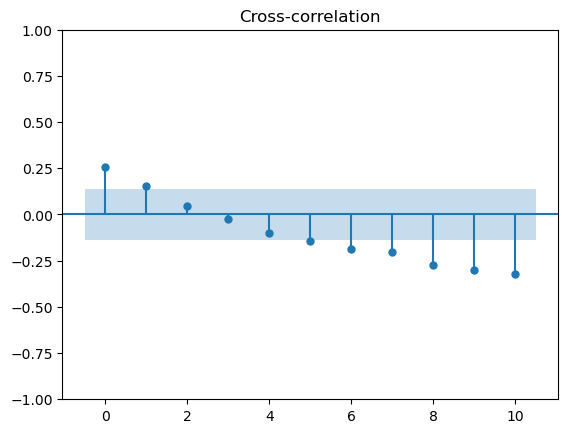

In [54]:
community_area = 1

variable = 'average_trip_total'

df_comm_area = df[df['pickup_community_area'] == community_area].iloc[:200]
ccf = plot_ccf(df_comm_area[variable], df_comm_area['target'], lags=10)

In [161]:
def get_shap_values(df, community):
    from xgboost import XGBRegressor
    df_com = df[df['pickup_community_area'] == community]
    train_com_X = df_com.drop(["target", "pickup_community_area"], axis=1)
    train_com_X = train_com_X.set_index("interval")
    train_com_y = df_com['target']

    xgb = XGBRegressor()

    xgb.fit(train_com_X, train_com_y)

    shap.initjs()

    explainer = shap.TreeExplainer(xgb)

    shapvalues = explainer.shap_values(train_com_X)

    return explainer, shapvalues, train_com_X

In [165]:
explainer, shap_vals, X_train = get_shap_values(df, community=8)

In [163]:
X_train.iloc[:1, :]

,num_rides,average_fare,average_trip_total,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,rain,trip_start_hour_sin,trip_start_hour_cos,trip_start_day_of_week_sin,trip_start_day_of_week_cos,fare_LT,trip_total_LT,num_rides_trip_start_hour_sin,num_rides_trip_start_hour_cos
interval,,,,,,,,,,,,,,,,,,,,
2020-03-09 10:00:00,107,8.948598,13.305234,12.8,0.5,43.0,0.0,220.0,33.5,1018.7,7.0,0,0.5,-0.866025,0.781831,0.62349,2.297432,2.660625,53.5,-92.664718


In [166]:
i = 1
shap.force_plot(explainer.expected_value, shap_vals[:i, :], X_train.iloc[:i, :])

In [63]:
abs(shap_vals.mean(axis=0))

array([3.6293653e-01, 2.0267409e-01, 9.0443306e-02, 4.7171362e-02,
       2.3724999e-02, 2.6663806e-02, 9.0448059e-02, 2.7952529e-04,
       1.9033778e-02, 2.1571983e-02, 4.2526040e-02, 1.0610649e-02,
       3.1250876e-01, 5.5671364e-01, 1.5811376e-01, 1.7572829e-02,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

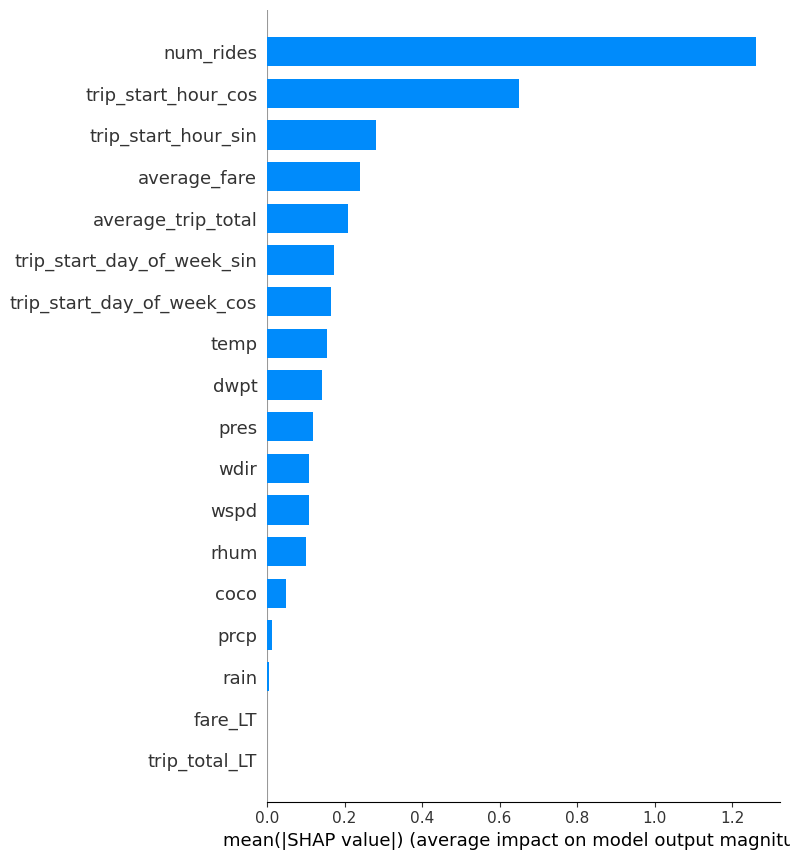

In [66]:
explainer, shap_vals, X_train = get_shap_values(df, community=8)
shap.summary_plot(shap_vals, X_train, plot_type="bar")

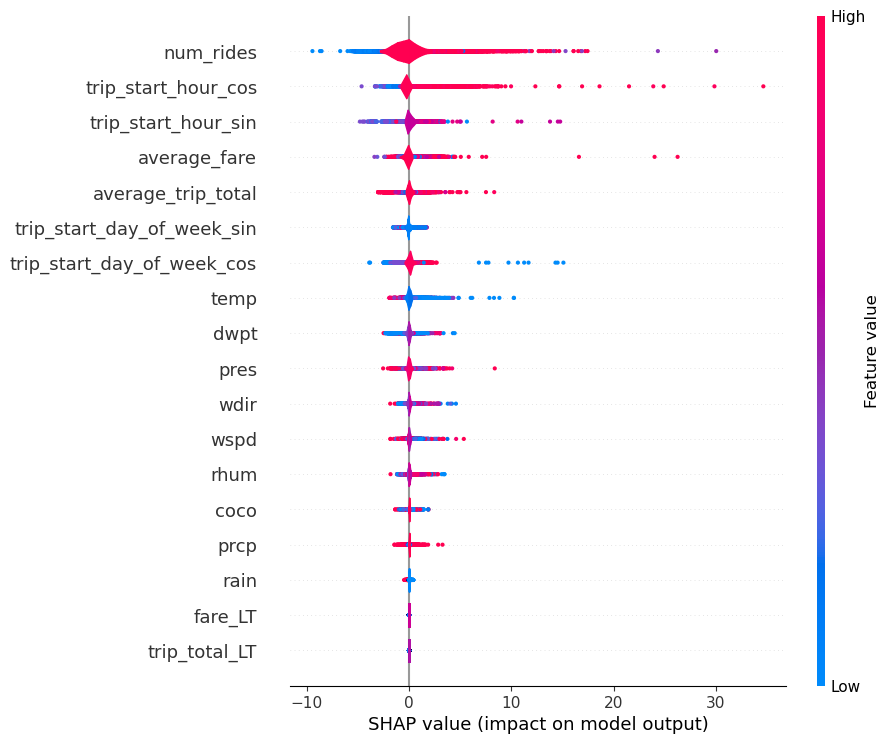

In [67]:
shap.violin_plot(shap_vals, X_train)

In [30]:
def fit_prophet_models(train, validation, columns):
    
    rename = {"interval": "ds", "target": "y"}
    train = train.rename(rename, axis=1)
    validation = validation.rename(rename, axis=1)

    models_per_community = {}
    
    for com in list(community_areas):
        train_com = train[train["pickup_community_area"] == com].sort_values(by='ds')
        
        val_com = validation[validation["pickup_community_area"] == com].sort_values(by='ds')
        n_val = val_com.shape[0]
        
        
        df_train = train_com[columns + ['y', 'ds']]
        
        df_val = val_com[columns + ['y', 'ds']]
        
        model = Prophet(
            changepoint_prior_scale=0.0001,
            daily_seasonality=True,
            yearly_seasonality=True,
            weekly_seasonality=True
        )

        for col in columns:
            model.add_regressor(col)

        model.add_country_holidays(country_name='US')
        model.fit(df_train)

        y_hat = model.predict(df_val)['yhat']
        
        mse = mean_squared_error(df_val['y'], y_hat)
        
        models_per_community[com] = {
            "model": model, 
            "mse": mse,
            "sample_size": n_val
        }
    return models_per_community

In [ ]:
columns = [
        "num_rides", "average_trip_total",
        "trip_start_day_of_week_sin", 
        "trip_start_day_of_week_cos", 
        "temp"]

models = fit_prophet_models(train, validation, columns=columns)


13:42:07 - cmdstanpy - INFO - Chain [1] start processing
13:42:09 - cmdstanpy - INFO - Chain [1] done processing
13:42:13 - cmdstanpy - INFO - Chain [1] start processing
13:42:16 - cmdstanpy - INFO - Chain [1] done processing
13:42:20 - cmdstanpy - INFO - Chain [1] start processing
13:42:22 - cmdstanpy - INFO - Chain [1] done processing
13:42:26 - cmdstanpy - INFO - Chain [1] start processing
13:42:28 - cmdstanpy - INFO - Chain [1] done processing
13:42:32 - cmdstanpy - INFO - Chain [1] start processing
13:42:33 - cmdstanpy - INFO - Chain [1] done processing
13:42:37 - cmdstanpy - INFO - Chain [1] start processing
13:42:40 - cmdstanpy - INFO - Chain [1] done processing
13:42:43 - cmdstanpy - INFO - Chain [1] start processing
13:42:47 - cmdstanpy - INFO - Chain [1] done processing
13:42:51 - cmdstanpy - INFO - Chain [1] start processing
13:42:53 - cmdstanpy - INFO - Chain [1] done processing
13:42:56 - cmdstanpy - INFO - Chain [1] start processing
13:42:57 - cmdstanpy - INFO - Chain [1]

In [ ]:
models

In [206]:
from typing import Any

def log_performance(models:dict[dict[str, Any]], model_name, model_logger,
                    predictors):
    run_name = f"{model_name}_" + str(random.randint(1000, 9999999))
    models_ = models.copy()
    with mlflow.start_run(run_name=run_name) as run:
        mse_total = 0
        for community, item in models_.items():
            print(f'logging community {community}')
            mse_total += item['mse']
            model_logger(
                item['model'], 
                name=f"{model_name}_{community}"
            )
            item.pop("model")
            mlflow.log_dict(item, artifact_file=f"{community}_metrics")

        total_mse = mse_total / len(models_)
        mlflow.log_metric("total_mse", value=total_mse)
        mlflow.log_param("features", value=predictors) 

        print(total_mse)

In [ ]:
log_performance(models, model_name="prophet_models", 
                model_logger=mlflow.prophet.log_model, predictors=columns)

### Check if target satisfies requirements for ARIMA

In [63]:
train_com1 = train[train["pickup_community_area"] == 4].set_index('interval')['target']

<Axes: ylabel='Frequency'>

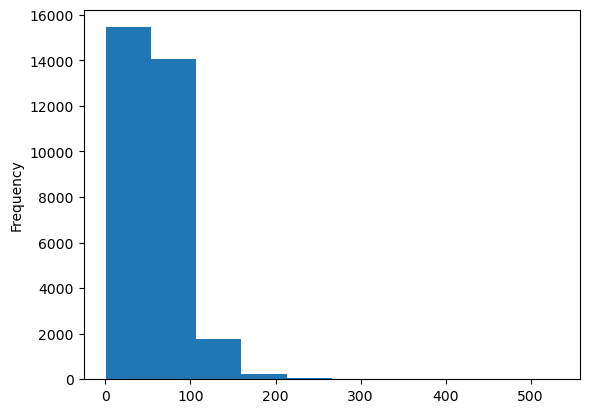

In [183]:
train_com1.plot(kind='hist')

In [184]:
print(train_com1.mean())
print(train_com1.var())

55.44657274022479
1243.5568671320648


<Axes: xlabel='interval'>

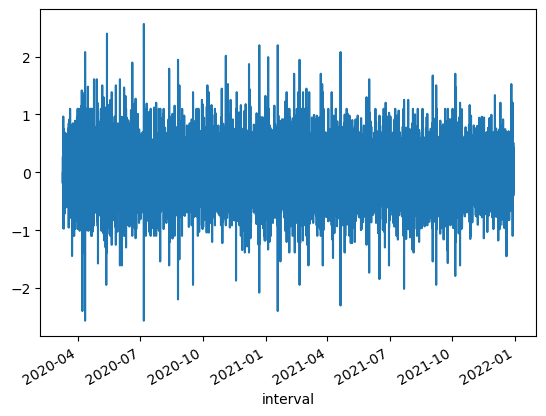

In [185]:
np.log(train_com1).diff().plot()

In [111]:
from statsmodels.tsa.stattools import adfuller
adfuller(
    x=np.log(train_com1).diff().dropna()
)


(-37.47021733426273,
 0.0,
 51,
 31631,
 {'1%': -3.4305567538415263,
  '5%': -2.861631379782367,
  '10%': -2.5668186386394765},
 -42552.361547452936)

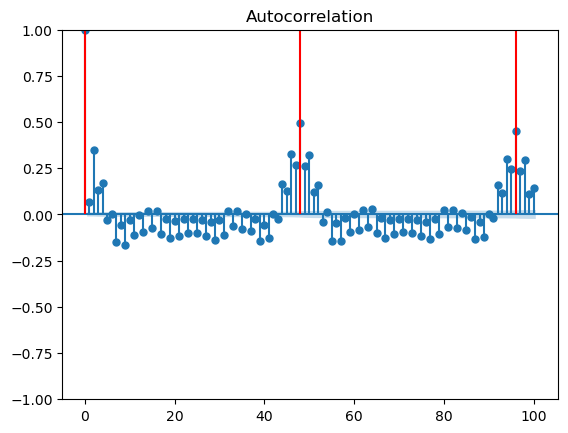

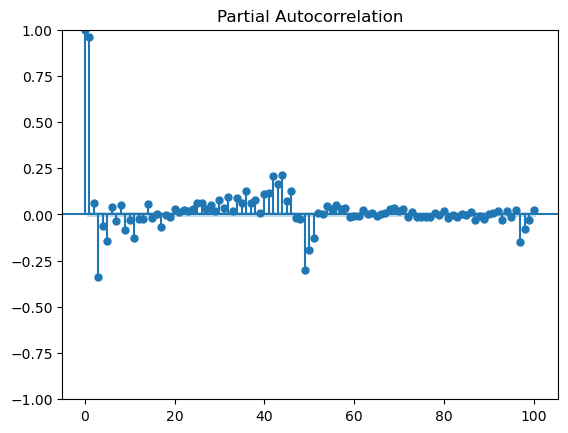

In [112]:
acf_plot = plot_acf(np.log(train_com1).diff().dropna(), lags = 100)
for i in range(0, 3):
    plt.vlines(x=i*48, ymin=0, ymax=1, color='red')

pacf = plot_pacf(train_com1, lags = 100)

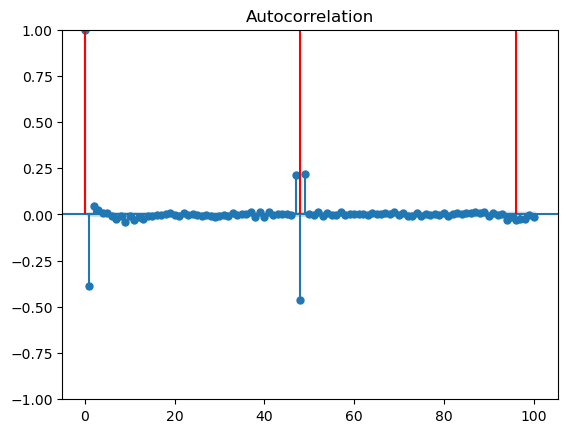

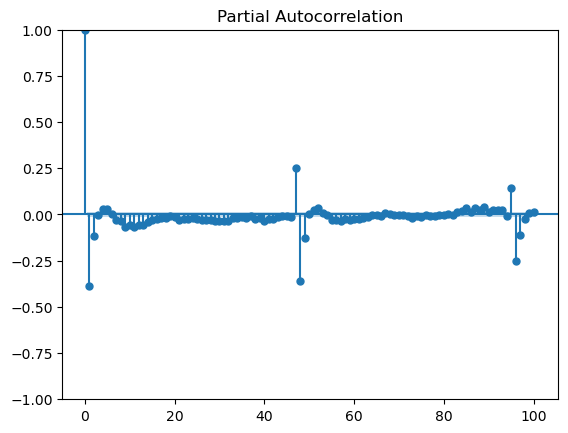

In [113]:
train_com1_seas_diff = np.log(train_com1).diff().dropna().diff(48).dropna()
acf_plot = plot_acf(train_com1_seas_diff, lags = 100)
for i in range(0, 3):
    plt.vlines(x=i*48, ymin=0, ymax=1, color='red')

pacf = plot_pacf(train_com1_seas_diff, lags = 100)

### Verify stationarity of variables for ARIMA to pottentially difference and test performance vs undifferenced variables

<Axes: xlabel='interval'>

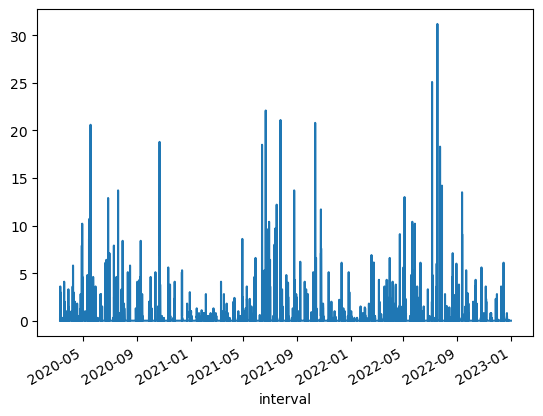

In [72]:
comm_8 = df[df['pickup_community_area'] == 8].set_index("interval")
comm_8["prcp"].plot()

In [62]:
comm_8_diff = comm_8.diff()

<Axes: xlabel='interval'>

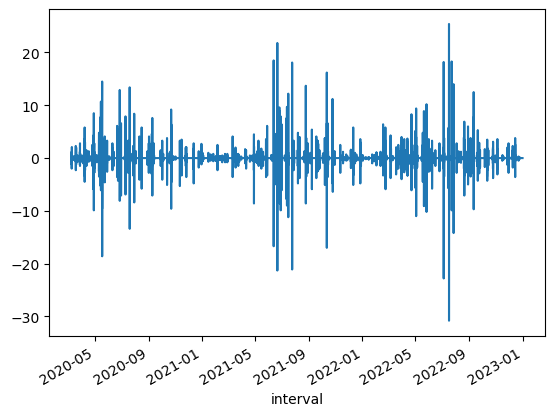

In [63]:
#differenced
comm_8_diff["prcp"].plot()

<Axes: xlabel='interval'>

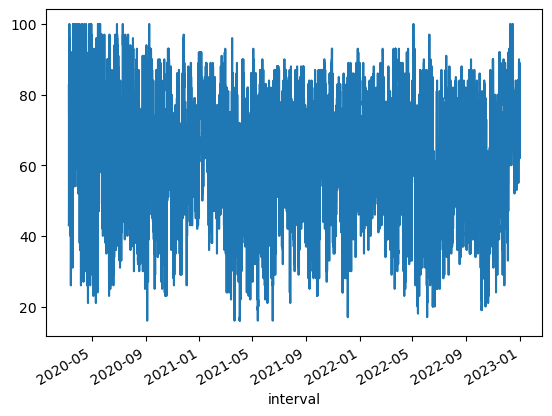

In [68]:
comm_8["rhum"].plot()

<Axes: xlabel='interval'>

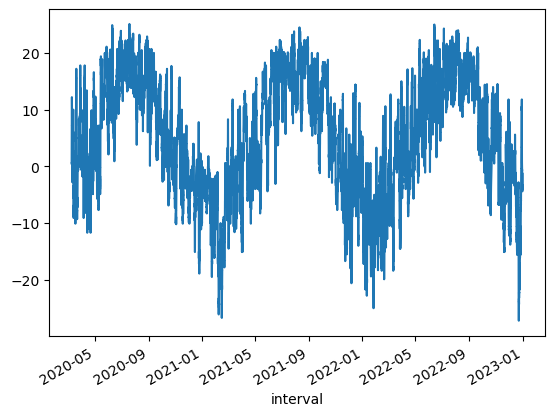

In [69]:
comm_8["dwpt"].plot()

<Axes: xlabel='interval'>

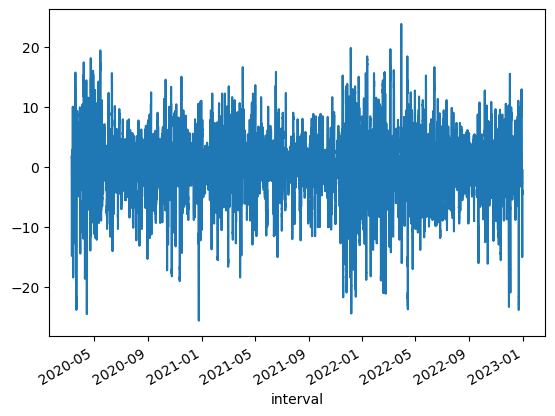

In [70]:
comm_8.diff(48)["dwpt"].plot()

<Axes: xlabel='interval'>

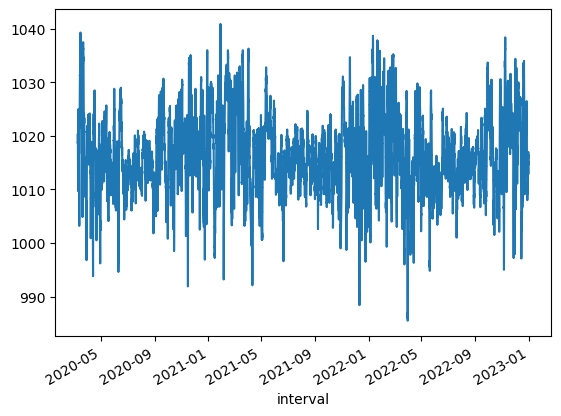

In [71]:
comm_8["pres"].plot()

<Axes: xlabel='interval'>

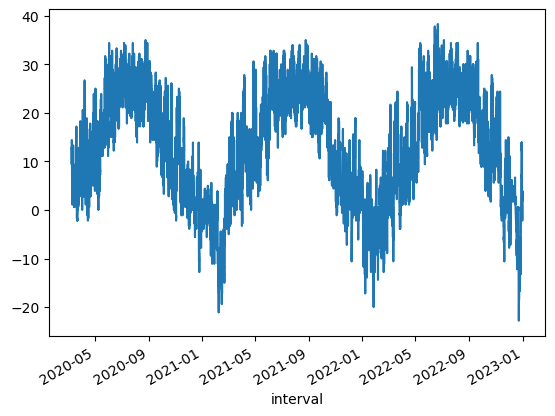

In [58]:
comm_8["temp"].plot()

<Axes: xlabel='interval'>

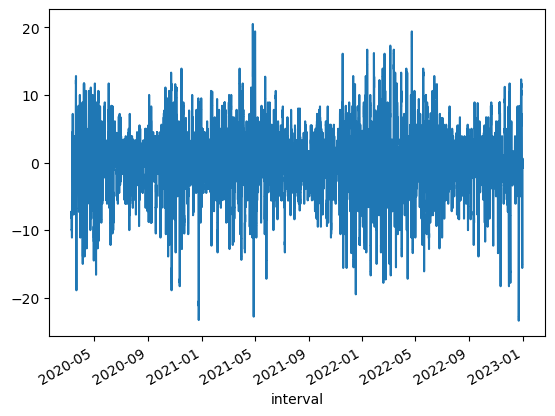

In [59]:
# Seasonal difference temperature
comm_8["temp"].diff(48).plot()

<Axes: xlabel='interval'>

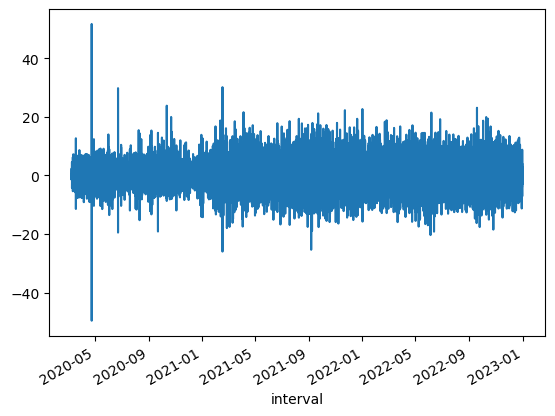

In [54]:
comm_8["average_trip_total"].diff().plot()

In [200]:
# Add differenced variables
df_diff = df.copy()

# add some laggs of num_rides
for lag in range(1, 10):
    df_diff[f'num_rides_lag{lag}'] = df_diff['num_rides'].shift(lag)


diffs = pd.DataFrame()

for key, val in df_diff.groupby(["pickup_community_area"]):
    diff = val.copy()
    diff["temp_diff"] = diff["temp"].diff(48)
    diff['average_fare_diff'] = diff['average_fare'].diff()
    diff['average_trip_total_diff'] = diff['average_trip_total'].diff()
    diff["dwpt_diff"] = diff["dwpt"].diff(48)
    diffs = pd.concat([diffs, diff], axis=0)

diffs = diffs.dropna()


In [201]:
diffs = diffs.sort_values(['interval', 'pickup_community_area'])

In [202]:
train_diff, test_diff = train_test_split(diffs, shuffle=False, test_size=0.2)
train_diff, validation_diff = train_test_split(train_diff, shuffle=False, test_size=0.2)

In [204]:
def fit_arima_models(train, validation, columns):
    
    train["pickup_community_area"] = train["pickup_community_area"].astype(int)

    train = train.set_index("interval")
    validation = validation.set_index("interval")

    train.index.freq = pd.infer_freq(train.index)
    validation.index.freq = pd.infer_freq(validation.index)

    models_per_community = {}
    
    for com in list(community_areas):
        train_com = train[train["pickup_community_area"] == com].iloc[-10000:]
        val_com = validation[validation["pickup_community_area"] == com]
        n_val = val_com.shape[0]

        y = np.log(train_com['target'])
        
        X = train_com[columns]
        X_val = val_com[columns]
        
        
        y_val = val_com['target']

        model = AutoARIMA(
            max_p=3, 
            max_q=3,
            start_P=0,
            start_Q=0,
            d=1,
            max_D=1,
            max_P=0,
            max_Q=0,
            n_jobs=4,
            maxiter=100
        )

        model.fit(y=y, X=X)

        fh = ForecastingHorizon(pd.date_range(start=y.index[-1] + pd.Timedelta(minutes=30),
                                      periods=len(X_val), freq="30T"),
                        is_relative=False)
        
        y_hat = model.predict(fh=fh, X=X_val)

        mse = mean_squared_error(y_val, np.exp(y_hat))
        
        models_per_community[com] = {
            "model": model, 
            "mse": mse,
            "sample_size": X_val.shape[0]
        }
    return models_per_community

In [ ]:
predictors = [
        "average_trip_total",
        "trip_start_hour_sin",
        "trip_start_hour_cos",
        "trip_start_day_of_week_sin", 
        "trip_start_day_of_week_cos", 
        "temp"]
models = fit_arima_models(train_diff, validation_diff, 
                          predictors)

# Note: autoarima was tested with sp=48 but was too computationally intensive

In [150]:
models

{1: {'model': AutoARIMA(d=1, max_P=0, max_Q=0, max_p=3, max_q=3, maxiter=100, n_jobs=4,
            start_P=0, start_Q=0),
  'mse': 1366.0388995000653,
  'sample_size': 7851},
 2: {'model': AutoARIMA(d=1, max_P=0, max_Q=0, max_p=3, max_q=3, maxiter=100, n_jobs=4,
            start_P=0, start_Q=0),
  'mse': 2268.681472617043,
  'sample_size': 7850},
 3: {'model': AutoARIMA(d=1, max_P=0, max_Q=0, max_p=3, max_q=3, maxiter=100, n_jobs=4,
            start_P=0, start_Q=0),
  'mse': 427.9360242188029,
  'sample_size': 7851},
 4: {'model': AutoARIMA(d=1, max_P=0, max_Q=0, max_p=3, max_q=3, maxiter=100, n_jobs=4,
            start_P=0, start_Q=0),
  'mse': 600.9151819092947,
  'sample_size': 7846},
 5: {'model': AutoARIMA(d=1, max_P=0, max_Q=0, max_p=3, max_q=3, maxiter=100, n_jobs=4,
            start_P=0, start_Q=0),
  'mse': 31333.329338745272,
  'sample_size': 7844},
 6: {'model': AutoARIMA(d=1, max_P=0, max_Q=0, max_p=3, max_q=3, maxiter=100, n_jobs=4,
            start_P=0, start_Q=0),


In [177]:
models[32]['model'].get_fitted_params()

{'intercept': -5.206938004518905e-05,
 'trip_total_LT': -0.0903397765846288,
 'trip_start_hour_sin': -0.6519732984318476,
 'trip_start_hour_cos': -0.5658381209385948,
 'trip_start_day_of_week_sin': -0.03487966474835177,
 'trip_start_day_of_week_cos': 0.08352017276738402,
 'temp_diff': 0.0030273152963741228,
 'ar.L1': -0.12620036967954248,
 'ar.L2': 0.7764148502415622,
 'ar.L3': 0.08348332123023952,
 'ma.L1': -0.1806048589502598,
 'ma.L2': -0.7922262404613899,
 'sigma2': 0.10219320183161955,
 'order': (3, 1, 2),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 1137.4466191477131,
 'aicc': 1137.6299944625746,
 'bic': 1210.2518494962183,
 'hqic': 1164.1798499483825}

In [ ]:
from sktime.utils import mlflow_sktime
log_performance(models, model_name="ARIMA", model_logger=mlflow_sktime.log_model,
                predictors=predictors)

In [ ]:
def fit_arima_models(train, validation, columns):
    
    train["pickup_community_area"] = train["pickup_community_area"].astype(int)
    train['interval'] = pd.to_datetime(train['interval'])
    validation['interval'] = pd.to_datetime(validation['interval'])

    train = train.set_index("interval")
    validation = validation.set_index("interval")

    train.index.freq = pd.infer_freq(train.index)
    validation.index.freq = pd.infer_freq(validation.index)

    models_per_community = {}
    
    for com in list(community_areas):
        print(f"estimating community {com}")
        train_com = train[train["pickup_community_area"] == com].iloc[-2000:]
        val_com = validation[validation["pickup_community_area"] == com]
        n_val = val_com.shape[0]

        y = np.log(train_com['target'])
        
        X = train_com[columns]
        X_val = val_com[columns]
        
        
        y_val = val_com['target']
        

        model = ARIMA(
            order=(3,1,2),
            maxiter=200,
        )

        model.fit(y=y, X=X)

        fh = ForecastingHorizon(pd.date_range(start=y.index[-1] + pd.Timedelta(minutes=30),
                                      periods=len(X_val), freq="30T"),
                        is_relative=False)
        
        y_hat = model.predict(fh=fh, X=X_val)

        mse = mean_squared_error(y_val, np.exp(y_hat))
        
        models_per_community[com] = {
            "model": model, 
            "mse": mse,
            "sample_size": X_val.shape[0]
        }
    return models_per_community

In [112]:
train_diff

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,target,temp,dwpt,rhum,prcp,...,num_rides_diff4,num_rides_diff5,num_rides_diff6,num_rides_diff7,num_rides_diff8,num_rides_diff9,temp_diff,average_fare_diff,average_trip_total_diff,dwpt_diff
3718,1,2020-03-10 10:00:00,77,10.519481,14.118961,59.0,2.8,2.2,96.0,0.0,...,2.0,24.0,8.0,47.0,30.0,58.0,-7.2,-2.026391,-2.120764,-2.2
3719,2,2020-03-10 10:00:00,59,11.313559,14.811017,135.0,2.8,2.2,96.0,0.0,...,13.0,2.0,24.0,8.0,47.0,30.0,-7.2,-0.035647,0.485461,-2.2
3720,3,2020-03-10 10:00:00,135,9.833333,13.969556,57.0,2.8,2.2,96.0,0.0,...,233.0,13.0,2.0,24.0,8.0,47.0,-7.2,-1.675047,-1.696366,-2.2
3721,4,2020-03-10 10:00:00,57,11.447368,15.358947,74.0,2.8,2.2,96.0,0.0,...,120.0,233.0,13.0,2.0,24.0,8.0,-7.2,0.741486,0.440241,-2.2
3722,5,2020-03-10 10:00:00,74,9.966216,14.026351,273.0,2.8,2.2,96.0,0.0,...,77.0,120.0,233.0,13.0,2.0,24.0,-7.2,-2.367117,-2.950049,-2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2361042,41,2021-12-30 00:00:00,10,11.500000,14.688000,13.0,2.2,-6.6,52.0,0.0,...,1.0,4.0,9.0,6.0,25.0,89.0,-1.1,-0.117647,0.353294,-8.3
2361043,42,2021-12-30 00:00:00,13,13.461538,16.254615,19.0,2.2,-6.6,52.0,0.0,...,16.0,1.0,4.0,9.0,6.0,25.0,-1.1,1.378205,1.172115,-8.3
2361044,43,2021-12-30 00:00:00,19,13.157895,16.522105,8.0,2.2,-6.6,52.0,0.0,...,8.0,16.0,1.0,4.0,9.0,6.0,-1.1,1.407895,1.495605,-8.3
2361045,44,2021-12-30 00:00:00,8,13.125000,16.600000,2.0,2.2,-6.6,52.0,0.0,...,8.0,8.0,16.0,1.0,4.0,9.0,-1.1,-2.208333,-1.188667,-8.3


In [133]:
predictors = [
        "average_trip_total",
        "trip_start_hour_sin",
        "trip_start_hour_cos",
        "trip_start_day_of_week_sin", 
        "trip_start_day_of_week_cos", 
        "temp"]
models = fit_arima_models(train_diff, validation_diff, 
                          predictors)

# Note: autoarima was tested with sp=48 but was too computationally intensive
# The last 100000 of train data values were sampled to speed up computation

estimating community 1


c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\armym\AppData\Local\Temp\ipykernel_8760\3643243559.py:38: FutureWarning: 'T' is deprecated and will be rem

estimating community 2


c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\armym\AppData\Local\Temp\ipykernel_8760\3643243559.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  fh = ForecastingHorizon(pd.date_range(start=y.index[-1] + pd.Timedelta(minutes=30),
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: 

estimating community 3


c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\armym\AppData\Local\Temp\ipykernel_8760\3643243559.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  fh = ForecastingHorizon(pd.date_range(start=y.index[-1] + pd.Timedelta(minutes=30),
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: 

estimating community 4


c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\armym\AppData\Local\Temp\ipykernel_8760\3643243559.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  fh = ForecastingHorizon(pd.date_range(start=y.index[-1] + pd.Timedelta(minutes=30),
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_pr

estimating community 5


c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\armym\AppData\Local\Temp\ipykernel_8760\3643243559.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  fh = ForecastingHorizon(pd.date_range(start=y.index[-1] + pd.Timedelta(minutes=30),
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_pr

estimating community 6


c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\armym\AppData\Local\Temp\ipykernel_8760\3643243559.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  fh = ForecastingHorizon(pd.date_range(start=y.index[-1] + pd.Timedelta(minutes=30),
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: 

estimating community 7


c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\armym\AppData\Local\Temp\ipykernel_8760\3643243559.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  fh = ForecastingHorizon(pd.date_range(start=y.index[-1] + pd.Timedelta(minutes=30),
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: 

estimating community 8


KeyboardInterrupt: 

In [131]:
from sktime.utils import mlflow_sktime
log_performance(models, model_name="ARIMA(3,1,2)", model_logger=mlflow_sktime.log_model,
                predictors=predictors)

2025/08/24 12:23:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 12:23:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/24 12:23:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 12:23:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/24 12:23:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 12:23:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/24 12:23:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use 

890724.7819414017
🏃 View run ARIMA(3,1,2)_3479694 at: http://10.0.0.3:5000/#/experiments/8/runs/ceee0bb1856e47b9a32c730fd080c8e9
🧪 View experiment at: http://10.0.0.3:5000/#/experiments/8


In [ ]:
from sklearn import set_config
set_config(transform_output="pandas")

In [195]:
def fit_poisson_models(train, validation, continuous_cols:list, descrete_cols:list):
    train = train.set_index("interval")
    validation = validation.set_index("interval")

    continuous_cols = continuous_cols + ['pickup_community_area', 'target']
    transformer = ColumnTransformer(
        [("continuous_transform", FunctionTransformer(lambda x: x), continuous_cols),
         ("descrete_transform", OneHotEncoder(sparse_output=False), descrete_cols)
         ],
         verbose_feature_names_out=False
    )

    train = transformer.fit_transform(train)
    validation = transformer.transform(validation)

    columns = list(train.columns.drop(["target", "pickup_community_area"]))

    models_per_community = {}
    
    for com in list(community_areas):
        train_com = train[train["pickup_community_area"] == com].copy()
        val_com = validation[validation["pickup_community_area"] == com].copy()
        
        lagged_var_names = []
        for i in range(1, 15):
            name = f'target_lagged_{i}'
            lagged_var_names.append(name)
            train_com.loc[:, name] = train_com['num_rides'].shift(i)
            val_com.loc[:, name]  = val_com['num_rides'].shift(i)

        train_com = train_com.dropna()
        val_com = val_com.dropna()


        train_X = sm.add_constant(train_com[columns + lagged_var_names])

        val_X = sm.add_constant(val_com[columns + lagged_var_names])


        model = Poisson(
            endog=train_com['target'].astype(int), 
            exog=train_X
        )

        fit = model.fit()

        y_hat = fit.predict(val_X)

        mse = mean_squared_error(val_com['target'], y_hat)
        
        models_per_community[com] = {
            "model": fit, 
            "mse": mse,
            "sample_size": val_com.shape[0]
        }
    return models_per_community

In [ ]:
predictors = [
    "num_rides",
    "average_trip_total",
    "trip_start_hour_sin",
    "trip_start_hour_cos",
    "trip_start_day_of_week_sin", 
    "trip_start_day_of_week_cos", 
    "temp"
    ]
models = fit_poisson_models(train, validation, continuous_cols=predictors, descrete_cols=[])

In [147]:
models

{1: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x1a5fc7d8590>,
  'mse': 186.44500751047767,
  'sample_size': 7858},
 2: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x1a5273d32d0>,
  'mse': 2169.1781371377265,
  'sample_size': 7857},
 3: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x1a549392610>,
  'mse': 337.1698321472086,
  'sample_size': 7858},
 4: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x1a5283491d0>,
  'mse': 481.6296041147329,
  'sample_size': 7854},
 5: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x1a5340da950>,
  'mse': 22026.694542548656,
  'sample_size': 7852},
 6: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x1a547f7fed0>,
  'mse': 14575.987770947575,
  'sample_size': 7858},
 7: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x1a547f7ee90>,
  'mse': 119416.9983404001,
  'sample_si

In [198]:
len(models)

77

In [182]:
fourth_com = models[7]

In [183]:
fourth_com["model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                 target   No. Observations:                31670
Model:                        Poisson   Df Residuals:                    31661
Method:                           MLE   Df Model:                            8
Date:                Mon, 25 Aug 2025   Pseudo R-squ.:                  0.7896
Time:                        14:48:49   Log-Likelihood:            -7.6818e+05
converged:                       True   LL-Null:                   -3.6514e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          4.7525      0.001   4461.373      0.000       4.750       4.755
average_trip_total             0.0107   4.99e-05    214.267      0.000       0.011       0.011
trip_start_hour_sin           -0.2432      0.001   -437.705      0.000      -0.244      -0.242
trip_start_hour_cos           -0.2360      0.000   -485.356      0.000      -0.237      -0.235
trip_start_day_of_week_sin    -0.0307      0.000    -62.300      0.000      -0.032      -0.030
trip_start_day_of_week_cos    -0.0157      0.000    -33.456      0.000      -0.017      -0.015
temp                           0.0041   3.07e-05    132.612      0.000       0.004       0.004
target_lagged_1                0.0014   4.86e-06    278.418      0.000       0.001       0.001
target_lagged_2                0.0004   4.92e-06     72.857      0.000       0.000       0.000
==============================================================================================
"""

In [199]:
log_performance(models, model_name="Poisson", model_logger=mlflow.statsmodels,
                predictors=predictors)

logging community 1
logging community 2
logging community 3
logging community 4
logging community 5
logging community 6
logging community 7
logging community 8
logging community 9
logging community 10
logging community 11
logging community 12
logging community 13
logging community 14
logging community 15
logging community 16
logging community 17
logging community 18
logging community 19
logging community 20
logging community 21
logging community 22
logging community 23
logging community 24
logging community 25
logging community 26
logging community 27
logging community 28
logging community 29
logging community 30
logging community 31
logging community 32
logging community 33
logging community 34
logging community 35
logging community 36
logging community 37
logging community 38
logging community 39
logging community 40
logging community 41
logging community 42
logging community 43
logging community 44
logging community 45
logging community 46
logging community 47
logging community 48
l

### Prepare data for spatial AR

In [15]:
multi_index = pd.MultiIndex.from_frame(diffs[["pickup_community_area", "interval"]])

In [16]:
df_multi = diffs.copy()
df_multi.index = multi_index

In [17]:
communities = df_multi.index.get_level_values(0).unique()
time_stamps = df_multi.index.get_level_values(1).unique()
full_index = pd.MultiIndex.from_product(
        [communities, time_stamps], names=["pickup_community_area", "interval"]
)

In [18]:
df_multi = df_multi.reindex(full_index)

In [19]:
df_multi = df_multi.drop(["pickup_community_area", "interval"], axis=1)

In [20]:
df_multi['target'] = df_multi['target'].fillna(0)

In [21]:
df_multi = df_multi.ffill()

In [22]:
df_multi.isna().any().any()

False

In [30]:
df_multi.head()

num_rides  average_fare  \
pickup_community_area interval                                       
1                     2020-03-10 10:00:00       77.0     10.519481   
                      2020-03-10 10:30:00       72.0     11.770833   
                      2020-03-10 11:00:00       75.0     11.633333   
                      2020-03-10 11:30:00       79.0     11.708861   
                      2020-03-10 12:00:00       57.0     12.236842   

                                           average_trip_total  target  temp  \
pickup_community_area interval                                                
1                     2020-03-10 10:00:00           14.118961    59.0   2.8   
                      2020-03-10 10:30:00           15.224583    67.0   2.8   
                      2020-03-10 11:00:00           15.617333    54.0   2.2   
                      2020-03-10 11:30:00           15.335949    59.0   2.2   
                      2020-03-10 12:00:00           16.473684    55.0   2.2   

                                           dwpt   rhum  prcp   wdir  wspd  \
pickup_community_area interval                                              
1                     2020-03-10 10:00:00   2.2   96.0   0.0  360.0  16.6   
                      2020-03-10 10:30:00   2.2   96.0   0.0  360.0  16.6   
                      2020-03-10 11:00:00   0.6   89.0   0.0  330.0  20.5   
                      2020-03-10 11:30:00   0.6   89.0   0.0  330.0  20.5   
                      2020-03-10 12:00:00   2.2  100.0   0.0  360.0  18.4   

                                           ...  num_rides_diff4  \
pickup_community_area interval             ...                    
1                     2020-03-10 10:00:00  ...              2.0   
                      2020-03-10 10:30:00  ...              3.0   
                      2020-03-10 11:00:00  ...              2.0   
                      2020-03-10 11:30:00  ...              5.0   
                      2020-03-10 12:00:00  ...              4.0   

                                           num_rides_diff5  num_rides_diff6  \
pickup_community_area interval                                                
1                     2020-03-10 10:00:00             24.0              8.0   
                      2020-03-10 10:30:00             25.0             10.0   
                      2020-03-10 11:00:00             24.0              7.0   
                      2020-03-10 11:30:00             16.0              6.0   
                      2020-03-10 12:00:00             22.0             11.0   

                                           num_rides_diff7  num_rides_diff8  \
pickup_community_area interval                                                
1                     2020-03-10 10:00:00             47.0             30.0   
                      2020-03-10 10:30:00             39.0             21.0   
                      2020-03-10 11:00:00             53.0             24.0   
                      2020-03-10 11:30:00             41.0             28.0   
                      2020-03-10 12:00:00             40.0             18.0   

                                           num_rides_diff9  temp_diff  \
pickup_community_area interval                                          
1                     2020-03-10 10:00:00             58.0       -7.2   
                      2020-03-10 10:30:00             47.0       -7.2   
                      2020-03-10 11:00:00             41.0       -7.2   
                      2020-03-10 11:30:00             41.0       -7.2   
                      2020-03-10 12:00:00             40.0       -7.2   

                                           average_fare_diff  \
pickup_community_area interval                                 
1                     2020-03-10 10:00:00          -2.026391   
                      2020-03-10 10:30:00           1.251353   
                      2020-03-10 11:00:00          -0.137500   
                      2020-03-10 11:30:00       

In [23]:
df_multi_flat = df_multi.reset_index()

In [24]:
n_intervals = int(df_multi_flat.shape[0]*0.8 // 77)

In [25]:
train = df_multi_flat.sort_values(['interval', 'pickup_community_area']).iloc[:n_intervals*77]
test = df_multi_flat.sort_values(['interval', 'pickup_community_area']).iloc[n_intervals*77:]

In [26]:
n_intervals = int(train.shape[0]*0.8 // 77)

validation = train.sort_values(['interval', 'pickup_community_area']).iloc[n_intervals*77:]
train = train.sort_values(['interval', 'pickup_community_area']).iloc[:n_intervals*77]

### Gather latest 1000 samples for each community due to Panel_FE_Lag being memory intensive

In [58]:
train_size = 2000
train_subset = train.groupby(["pickup_community_area"]).tail(train_size)
val_subset = validation

In [91]:
predictors = [
    'num_rides',
    'num_rides_diff1',
    'num_rides_diff2',
    'average_trip_total',
    'trip_start_hour_sin',
    'trip_start_hour_cos',
    'trip_start_day_of_week_sin',
    'trip_start_day_of_week_cos',
    'temp'
 ]

In [92]:
x = train_subset[predictors].values

In [93]:
x_val = val_subset[predictors].values

In [94]:
x = x.reshape(-1, len(predictors))
x_val = x_val.reshape(-1, len(predictors))

In [95]:
y = train_subset['target'].values.reshape(-1,1)
y_val = val_subset['target'].values.reshape(-1,1)

In [96]:
y.shape

(154000, 1)

In [97]:
x.shape

(154000, 9)

In [98]:
from spreg import Panel_FE_Lag
import libpysal

w = libpysal.weights.full2W(A)

model = Panel_FE_Lag(y, x, w=w, name_y='rides')

In [83]:
print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG PANEL - FIXED EFFECTS
-----------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       rides                Number of Observations:      154000
Mean dependent var  :      0.0000                Number of Variables   :           9
S.D. dependent var  :     62.7456                Degrees of Freedom    :      153991
Pseudo R-squared    :      0.1939
Spatial Pseudo R-squared:  0.1487
Sigma-square ML     :    3181.314                Log likelihood        :-1760865.799
S.E of regression   :      56.403                Akaike info criterion : 3521749.598
                                                 Schwarz criterion     : 3521839.100

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------

In [99]:
train_mse = (model.u**2).mean()
train_mse

3108.1161934356874

In [100]:
y_last = y[-77:]
X_new = x_val[:77]

In [101]:
run_name = "spatialAR_" + str(random.randint(1000, 9999999))
with mlflow.start_run(run_name=run_name) as run:
    rho = model.rho
    beta = model.betas.flatten()[:-1] 


    W_array = w.full()[0]
    errors = []

    ones = np.ones(shape=(77, 1))
    for key, val in val_subset.groupby(["interval"]):
        # Predict next period
        
        
        try:
            X_new = val[predictors].values
            y_pred = (rho * W_array @ y_last) + X_new @ beta.reshape(-1, 1)
            y_last = y_pred

            error = y_pred - val['target'].to_numpy().reshape(-1,1) 
            errors.extend(error.tolist())
        except ValueError as e:
            print(e)

    mse = (np.array(errors)**2).mean()
    print(mse)
    mlflow.log_metric("mse", mse)
    mlflow.log_param("predictors", predictors)
    mlflow.log_metric("train_size", train_size)

11322.703217528971
🏃 View run spatialAR_7530288 at: http://10.0.0.3:5000/#/experiments/8/runs/f55dce608fb0488e99177405620443a3
🧪 View experiment at: http://10.0.0.3:5000/#/experiments/8


### Prepare data for spatio-temporal graph neural networks

In [ ]:
processed_data_path = "./data/processed_data.csv"
df.to_csv(processed_data_path)

In [4]:
processed_data_path = "./data/processed_data.csv"
df = pd.read_csv(processed_data_path, index_col=0)

In [ ]:
df = df.drop(['fare_LT', 'trip_total_LT', 'rain'], axis=1)

In [6]:

groups = ['interval']
graph_ts = df.groupby(groups)[df.columns.drop(groups)]
community_areas = set(df['pickup_community_area'].unique())

In [7]:
weather_features = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres',
       'coco']

In [8]:
def fill_absent_communities(X):
    """
    For a time stamp t we observe a matrix (n_nodes, n_features). If a community had no counts at time t, then
    n_nodes will be less than expected so we just insert the node into the observation with default values.
    Note: this process could probably be sped up by using pd.MultiIndex.from_product(
        [communities, time_stamps], names=["pickup_community_area", "random_time_stamp"]
    ) instead then a ffill after (needs to be implemented)
    :param X:
    :return:
    """
    missing_com = community_areas - set(X['pickup_community_area'])

    day_of_week_sin = X["trip_start_day_of_week_sin"].iat[0]
    day_of_week_cos = X["trip_start_day_of_week_cos"].iat[0]

    hour_sin = X["trip_start_hour_sin"].iat[0]
    hour_cos = X["trip_start_hour_cos"].iat[0]

    def fill_val(val=None):
        if val:
            return [val for com in missing_com]
    
        return [0 for com in missing_com]
    
    columns = X.columns.drop(
        ["pickup_community_area",
         "trip_start_day_of_week_sin",
         "trip_start_day_of_week_cos",
         "trip_start_hour_sin",
         "trip_start_hour_cos"] + weather_features
    )

    data = {
        "pickup_community_area": [com for com in missing_com],
        "trip_start_day_of_week_sin": fill_val(day_of_week_sin),
        "trip_start_day_of_week_cos": fill_val(day_of_week_cos),
        "trip_start_hour_sin": fill_val(hour_sin),
        "trip_start_hour_cos": fill_val(hour_cos)
    }

    # Fill in the weather
    for weather_fet in weather_features:
        data.update({weather_fet: fill_val(X[weather_fet].iloc[-1])})
    
    # Fill in other unknown columns with 0
    more_data = {
        col: fill_val() for col in columns
    }

    data.update(more_data)
        
    new_df = pd.DataFrame(data)

    # Make sure oickup communities always in correct order
    X = pd.concat([X, new_df], axis=0, ignore_index=True)\
        .sort_values(by="pickup_community_area") 
    return X


features = []
targets = []
for g, val in graph_ts:

    val = fill_absent_communities(val)
   
    feat = val.drop(['pickup_community_area', 'target'], axis=1)\
        .to_numpy()

    
    trgts = val['target'].to_numpy()
    
    features.append(feat)
    targets.append(trgts)

In [9]:
len(features)

49320

In [10]:
np.isnan(np.array(features)).any()

False

In [118]:
features[0].shape

(77, 15)

In [119]:
features = np.array(features)

In [13]:
test_data = [
    np.array([[1,2],[1, 2]]),
    np.array([[3,4], [3,4]]),
    np.array([[5,6], [5,6]])
]

In [55]:
test_data

array([[[1, 2],
        [1, 2]],

       [[3, 4],
        [3, 4]],

       [[5, 6],
        [5, 6]]])

In [14]:
np.array(test_data).shape

(3, 2, 2)

In [15]:
test_data = np.array(test_data)

In [11]:
def lag_features_np(features, n_time_steps_back):
    """Reduced memory consumption of this algorithm by 100% by efficiently using numpy"""
    features = np.flip(features, axis=0)
    added_lagged_features = np.empty(
        (
            len(features) - n_time_steps_back, 
            1 + n_time_steps_back, 
            features.shape[1], 
            features.shape[2]
        )
    )
    
    for i, X in enumerate(features[:len(features) - n_time_steps_back]):
        i_old = i
        
        lagged = np.empty(
            (
                n_time_steps_back + 1, 
                features.shape[1], 
                features.shape[2]
            )
        )
        
        i += n_time_steps_back + 1

        
        lagged[0,:,:] = X

        # Loop over n_time_steps previous feature matrices up to current time i
        for j, X_lagged in enumerate(features[i - n_time_steps_back: i]): 
            lagged[j+1,:,:] = X_lagged
    
        
        added_lagged_features[i_old, :, :, :] = lagged
    
    added_lagged_features = np.flip(added_lagged_features, axis=0)
    added_lagged_features = np.flip(added_lagged_features, axis=1)
    
    return added_lagged_features

In [72]:
def lag_features(features, n_time_steps_back):
    added_lagged_features = []
    
    for i, X in enumerate(features[:len(features) - n_time_steps_back]):
        
        i += n_time_steps_back + 1
        #print(i, i - n_time_steps_back + 1, i)
        lagged = [X.tolist()]

        # Loop over n_time_steps previous feature matrices up to current time i
        for X_lagged in features[i - n_time_steps_back: i]:
            #print(X_lagged)
            lagged.append(X_lagged.tolist())
        #assert len(lagged) == n_time_steps_back - 1, i
        added_lagged_features.append(lagged)
    
    return added_lagged_features

In [120]:
lagged= lag_features_np(test_data, 1)

In [121]:
lagged

array([[[[1., 2.],
         [1., 2.]],

        [[3., 4.],
         [3., 4.]]],


       [[[3., 4.],
         [3., 4.]],

        [[5., 6.],
         [5., 6.]]]])

In [68]:
np.array(lagged)

array([[[[3.00e+000, 4.00e+000],
         [3.00e+000, 4.00e+000]],

        [[0.00e+000, 0.00e+000],
         [0.00e+000, 0.00e+000]]],


       [[[5.00e+000, 6.00e+000],
         [5.00e+000, 6.00e+000]],

        [[2.32e-322, 2.57e-322],
         [2.72e-322, 1.28e-322]]]])

In [20]:
np.array(lagged).shape

(1, 3, 2, 2)

In [12]:
n_time_steps_back = 15

In [13]:
added_lagged_features = lag_features_np(features, 15)

In [87]:
added_lagged_features[:1]

array([[[[ 8.90000000e+01,  1.13764045e+01,  1.52259551e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01],
         [ 6.80000000e+01,  1.02205882e+01,  1.32097059e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01],
         [ 1.56000000e+02,  1.03525641e+01,  1.45732692e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01],
         ...,
         [ 8.00000000e+00,  1.46875000e+01,  1.81375000e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01],
         [ 2.96000000e+02,  2.55152027e+01,  3.65071622e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01],
         [ 9.30000000e+01,  1.11559140e+01,  1.56206452e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01]],

        [[ 8.90000000e+01,  1.09831461e+01,  1.46742697e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01],
         [ 7.00000000e+01,  1.13928571e+01,  1.47520000e+01, ...,
          -8.66025404e

In [14]:
added_lagged_features.shape

(49305, 16, 77, 15)

In [15]:
n_time_steps = df['interval'].nunique() - n_time_steps_back

In [16]:
n_time_steps

49305

In [17]:
len(added_lagged_features)

49305

In [36]:
edges = [edges_np for i in range(n_time_steps)]

edge_weights_list = [edge_weights for i in range(n_time_steps)]

In [37]:
assert len(edges) == len(added_lagged_features)
assert len(edges) == len(edge_weights_list)
assert len(edges[0]) == len(edge_weights_list[0])

In [38]:
dataset = StaticGraphTemporalSignal(
    edge_index=edges_np.T,
    edge_weight=edge_weights,
    features=added_lagged_features,
    targets=targets[n_time_steps_back:],
) 

In [39]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.80)
train_dataset, validation = temporal_signal_split(train_dataset, train_ratio=0.80)

In [40]:
class TensorStandardizer:
    def __init__(self):
        self.means = None
        self.stds = None

    def fit(self, x:torch.Tensor, dim: int | tuple):
        self.means = torch.mean(x, dim=dim)
        self.stds = torch.std(x, dim=dim)

    def transform(self, x:torch.Tensor):
        return (x - self.means) / self.stds

    def fit_transform(self, x:torch.Tensor, dim: int | tuple):
        self.fit(x, dim)
        return self.transform(x)
    
    def save_means_stds(self, means_path, stds_path):
        if self.means is not None:
            np.save(means_path, self.means.numpy())

        if self.stds is not None:
            np.save(stds_path, self.means.numpy())

    def load_means_stds(self, means_path, stds_path):
        self.means = torch.tensor(np.load(means_path), dtype=torch.float64)
        self.stds = torch.tensor(np.load(stds_path), dtype=torch.float64)



In [41]:
standardizer = TensorStandardizer()

### Only standardize non-cyclical data

In [42]:
features_tensor = torch.tensor(train_dataset.features.copy())
# up to 11 continuous variables
train_dataset.features[:,:,:, :11] = standardizer.fit_transform(features_tensor[:,:,:, :11], dim=(0,1))

In [63]:
standardizer.save_means_stds("standardizer_means.npy", "standardizer_stds.npy")

In [43]:
validation.features[:,:,:, :11] = standardizer.transform(torch.tensor(validation.features.copy()[:,:,:, :11]))

In [44]:
test_dataset.features[:,:,:, :11] = standardizer.transform(torch.tensor(test_dataset.features.copy()[:,:,:, :11]))

In [45]:
print(torch.isnan(features_tensor).any())

tensor(False)


In [ ]:
for i, j in enumerate(train_dataset):
    print(j.x.shape)
    print(j.edge_index.shape)
    print(j.edge_index.max())
    print(j.edge_index.min())
    print(j.edge_attr.shape)
    break

In [50]:
class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(TemporalConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))

    def forward(self, X):
        X = X.permute(0, 3, 1, 2)
        temp = self.conv1(X) + torch.sigmoid(self.conv2(X))
        out = F.relu(temp + self.conv3(X))
        # (batch_size, num_nodes, n_timesteps_out, n_features_out=out_channels)
        out = out.permute(0, 2, 3, 1)
        return out

In [51]:
class SpatialTemporalModel(nn.Module):
    def __init__(self, n_nodes, in_channels, n_time_steps_input, H=1, 
                 kernel_size=3):
        super(SpatialTemporalModel, self).__init__()
        self.H = H
        self.kernel_size = kernel_size
        self.STConv1 = STConv(
            num_nodes=n_nodes,
            in_channels=in_channels,
            hidden_channels=16,
            out_channels=64,
            kernel_size=3,
            K=1
        )

        self.STConv2 = STConv(
            num_nodes=n_nodes,
            in_channels=64,
            hidden_channels=16,
            out_channels=64,
            kernel_size=3,
            K=1
        )

        self.last_temporal = TemporalConv(in_channels=64, out_channels=64)

        linear_size = n_time_steps_input - 2*(2*(self.kernel_size-1)) - self.kernel_size + 1

        self.linear = nn.Linear(linear_size*64, 1)

        self.softplus = nn.Softplus()


    def forward(self, x:torch.Tensor, edge_index, weight_index):
        x = self.STConv1(x, edge_index, weight_index)
        x = self.STConv2(x, edge_index, weight_index)
        
        x = x.permute(0, 2, 1, 3)
        x = self.last_temporal(x)

        x = self.linear(x.reshape((x.shape[0], x.shape[1], -1)))
        x = self.softplus(x)
        return x.squeeze(dim=(0,1))

In [140]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [141]:
device

device(type='cuda', index=0)

In [46]:
from torch.utils.data import Dataset

class TemporalGraphDataset(Dataset):
    def __init__(self, dataset: StaticGraphTemporalSignal):
        self.features = dataset.features.copy()
        self.targets = dataset.targets.copy()
        self.edge_index = torch.tensor(dataset.edge_index.copy(), dtype=torch.long)
        self.edge_attr = torch.tensor(dataset.edge_weight.copy())
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {
            'x': torch.tensor(self.features[idx], dtype=torch.float),
            'y': torch.tensor(self.targets[idx], dtype=torch.float),
            'edge_index': self.edge_index,
            'edge_attr': self.edge_attr
        }
        

In [47]:
train_torch_dataset = TemporalGraphDataset(train_dataset)
validation_torch_dataset = TemporalGraphDataset(validation)
test_torch_dataset = TemporalGraphDataset(test_dataset)

In [48]:
batch_size = 64

In [49]:
train_loader = torch.utils.data.DataLoader(train_torch_dataset, batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_torch_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_torch_dataset, batch_size=batch_size, shuffle=False)

In [ ]:

print(f"training on {device}")

def train(
        n_features,
        model,
        optimizer,
        train_loader,
        validation_loader,
        saved_model_path,
        checkpoints_path,
        n_epochs=50,
        check_point_interval=10
):
    loss = PoissonNLLLoss(log_input=False)
    mse = nn.MSELoss()

    cost_list, val_cost_list, mse_list, val_mse_list = [], [], [], []

    best_val_loss = 10000000
    best_val_epoch = None
    for epoch in tqdm(range(n_epochs)):
        cost = 0
        mse_total = 0

        for timestamp, snapshot in enumerate(train_loader):
            model.train()
            
            optimizer.zero_grad()

            x = snapshot['x']
            
            n_nodes = x.shape[2]
            n_features = x.shape[-1]
            
            if x.dim() == 2:
                x = x.permute(1,0).unsqueeze(-1)
            
            x = x.view(-1, n_time_steps_back + 1 , n_nodes, n_features)


            edge_index = snapshot['edge_index'][0, :, :]
            edge_attr = snapshot['edge_attr'][0, :]
            
            start = time.time()
            y_hat = model(x, edge_index, edge_attr)

            # Get a time for how fast each forward pass is
            if epoch == 0 and timestamp == 0:
                end = time.time()
                print(f"Elapsed time: {end - start:.4f} seconds")
            
            y = snapshot['y']
            y = y.view(-1, 77, 1).squeeze()
            batch_loss = loss(y_hat.squeeze(), y)
            cost = cost + batch_loss.item()

            mse_batch = mse(y_hat.squeeze(), y)
            mse_total = mse_total + mse_batch.item()
            mse_batch.backward()
            optimizer.step()
        

        with torch.no_grad():
            val_loss = 0
            val_mse_total = 0
            model.eval()
            for timestamp, snapshot in enumerate(validation_loader):
                x = snapshot['x']
                n_nodes = x.shape[1]
                n_features = x.shape[-1]

                if x.dim() == 2:
                    x = x.permute(1,0).unsqueeze(-1)
                
                x = x.view(-1, n_time_steps_back + 1 , 77, n_features)

                y_hat = model(x, edge_index, edge_attr)

                y = snapshot['y']
                y = y.view(-1, 77, 1).squeeze()
                val_batch_loss = loss(y_hat.squeeze(), y)
                
                val_loss = val_loss + val_batch_loss.item()
                val_mse_total += mse(y_hat.squeeze(), y).item()
            
            # Save model if it improves compared to best_val_loss
            if val_mse_total < best_val_loss:
                print("Saving current best model")
                torch.save(model.state_dict(), saved_model_path)
                best_val_loss = val_mse_total
                best_val_epoch = epoch
            
            
            val_cost_list.append(val_loss / (timestamp + 1))
            val_mse_list.append(val_mse_total / (timestamp + 1))
            print(f"val_loss: {val_loss / (timestamp + 1)}")
            print(f"val_mse_total: {val_mse_total / (timestamp + 1)}")

        cost_list.append(cost)
        mse_list.append(mse_total / (timestamp + 1))
        
        # Checkpoint model
        if (epoch + 1) % check_point_interval == 0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_mse_total
                }, f'{checkpoints_path}/checkpoint_{epoch}_{batch_size}.pth'
            )
            
        #if epoch % 10 ==0:         
        cost = cost / (timestamp + 1)
        print(f"NNL: {cost}")
        print(f"MSE: {mse_total / (timestamp + 1)}")
        
    return cost_list, val_cost_list, mse_list, val_mse_list, best_val_loss, best_val_epoch

training on cuda:0


In [198]:
for i in train_loader:
    print(i['x'][0,:,:,:].squeeze(0).shape)
    input_example = {
        'x': i['x'][0,:,:,:].squeeze(0).numpy().tolist(),
        'edge_index': i['edge_index'][0, :, :].squeeze(0).numpy().tolist(),
        'edge_attr': i['edge_attr'][0, :].squeeze(0).numpy().tolist()
    }
    break

torch.Size([16, 77, 15])


In [ ]:
class GraphModel(mlflow.pyfunc.PythonModel):
    """
    Wraps SpatialTemporalModel into a pyfunc PythonModel
    """
    def __init__(self, model, standardizer):
        self.model = model
        self.model.eval()
        self.standardizer = standardizer
        self.edge_index = None
        self.edge_attr = None

    def predict(self, context, model_input: List[GraphInput], params=None) -> list[list[Any]]:
        """
        :param context:
        :param model_input: list[dict[str, float]] formatted as {
            'x': nested lists shaped (n_time_steps, n_nodes, n_features),
            'edge_index': list of edge indices,
            'edge_attr': list array of edge weights
        }
        :param params:
        :return: np.ndarray
        """
        predictions = []
        for item in model_input:
            x = item.x
            x = torch.tensor(x, dtype=torch.float).unsqueeze(0)
            x = self.standardize(x)

            edge_index = torch.tensor(self.edge_index, dtype=torch.int64)
            edge_attr = torch.tensor(self.edge_attr)

            with torch.no_grad():
                out = self.model(x, edge_index, edge_attr)
                predictions.append(out.numpy().tolist())
        return predictions

    def load_context(self, context):
        self.edge_index = np.load(context.artifacts["edges_npy"]).T
        self.edge_attr = np.load(context.artifacts["edge_weights_npy"])

    def standardize(self, x: torch.Tensor) -> torch.Tensor:
        x[:, :, :, :11] = self.standardizer.transform(x[:, :, :, :11])
        return x

In [ ]:
name = "SpatialTemporalGNN" + str(random.randint(10000, 999999))
with mlflow.start_run(run_name=name) as run:
    n_features = train_dataset.features.shape[-1]
    n_time_steps_input = 16
    
    model = SpatialTemporalModel(
        in_channels=n_features, n_nodes=77, n_time_steps_input=n_time_steps_input
    )

    lr = 0.001
    weight_decay = 1e-4
    n_epochs = 40

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    mlflow.log_params({
        "lr": lr,
        "weight_decay": weight_decay,
        "n_time_steps_input": n_time_steps_input,
        "n_features": n_features,
        "batch_size": batch_size,
        "n_epochs": n_epochs
    })

    losses = train(
        n_features=n_features,
        model=model,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=validation_loader,
        saved_model_path="models/SpatialTemporalv1.pth",
        checkpoints_path="./model_checkpoints",
        check_point_interval=2,
        n_epochs=n_epochs
    )

    mlflow.log_metrics({
        "BestValidationMSE": losses[-2],
        "BestValidationEpoch": losses[-1]
    })

    mlflow.log_dict({
        "PoissonNLL": losses[0],
        "ValidationPoissonNLL": losses[1],
        "MSE": losses[2],
        "ValidationMSE": losses[3]
    }, "performance.json")

    # Log best model
    best_model = SpatialTemporalModel(in_channels=n_features, n_time_steps_input=16, n_nodes=77)
    best_model.load_state_dict(torch.load("models/SpatialTemporalv1.pth", weights_only=True))

    best_model_pyfunc = GraphModel(model, standardizer)

    for i in train_loader:
        print(i['x'][0, :, :, :].squeeze(0).shape)
        input_example = [{
            'x': i['x'][0, :, :, :].squeeze(0).numpy().tolist(),
        }]
        break

    mlflow.pyfunc.log_model(
        python_model=best_model_pyfunc,
        name="model",
        conda_env="conda.yaml",
        code_paths=['model_code.py'],
        input_example=input_example,
        artifacts={
            "edge_weights_npy": "graph_files/edge_weights.npy",
            "edges_npy": "graph_files/edges.npy"
        }
    )

Since the Spatio-Temporal Graph Convolutional Network has lower validation loss, we choose it and test

In [52]:
n_features = train_dataset.features.shape[-1]
model2 = SpatialTemporalModel(in_channels=n_features, n_time_steps_input=16, n_nodes=77)
model2.load_state_dict(torch.load("models/SpatialTemporalv1.pth", weights_only=True))

<All keys matched successfully>

### Testing

In [57]:
test_mse = 0
loss = PoissonNLLLoss(log_input=False)
mse = nn.MSELoss()
model2.eval()
with torch.no_grad():
    val_loss = 0
    val_mse_total = 0
    for timestamp, snapshot in enumerate(test_loader):
        n_nodes = snapshot['x'].shape[1]
        n_features = snapshot['x'].shape[2]
        x = snapshot['x']
        
        #x = x.unsqueeze(0)

        ei = snapshot['edge_index'][0, :, :]
        ea = snapshot['edge_attr'][0, :]

        y_hat = model2(x, ei, ea)
        y = snapshot['y']
        
        test_mse += mse(y_hat.squeeze(), y)


    print(f"test_mse_total: {test_mse / (timestamp+1)}")

test_mse_total: 1378.7193603515625
